In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.table import Table

### Load data

In [300]:
apogee = Table.read('/data/jls/GaiaDR2/spectro/APOGEE_distances_withPRIOR_MASTER.hdf5')
apogee_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/APOGEE_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(apogee['flag']==0.), 'out of', len(apogee)
rave = Table.read('/data/jls/GaiaDR2/spectro/RAVE_DR5_distances_withPRIOR_MASTER.hdf5')
rave_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/RAVE_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(rave['flag']==0.), 'out of', len(rave)
ges = Table.read('/data/jls/GaiaDR2/spectro/GES_DR3_distances_withPRIOR_MASTER.hdf5')
ges_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/GES_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(ges['flag']==0.), 'out of', len(ges)
galah = Table.read('/data/jls/GaiaDR2/spectro/GALAH_distances_withPRIOR_MASTER.hdf5')
galah_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/GALAH_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(galah['flag']==0.), 'out of', len(galah)
lamost = Table.read('/data/jls/GaiaDR2/spectro/LAMOST_distances_withPRIOR_MASTER.hdf5')
lamost_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/LAMOST_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(lamost['flag']==0.), 'out of', len(lamost)
raveON = Table.read('/data/jls/GaiaDR2/spectro/RAVE_Cannon_distances_withPRIOR_MASTER.hdf5')
raveON_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/RAVEON_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(raveON['flag']==0.), 'out of', len(raveON)

from astropy.table import Table, vstack, join

def flag_errors(data, covar_correction=True):
    for col in ['dist_err', 'par_err', 'dm_err',
                'log10_teff_err', 'logg_err', 'log10_av_err',
                'log10_age_err',
                'mass_err',
                'Z_err', 'dm_log10age_corr', 'log10age_Z_corr', 'dm_Z_corr']:
        data['flag'][(data['flag'] == 0) & (data[col] != data[col])] = 6
        data['flag'][(data['flag'] == 0) & (data[col] == 0.)] = 6
    data['flag'][(data['log10_age'] < -1)&(data['logg']>3.5)&(data['log10_teff']<3.9)] = 7
    for col in ['dm_log10age_corr', 'log10age_Z_corr', 'dm_Z_corr']:
        data['flag'][(data['flag'] == 0) & (np.abs(data[col]) > 1.)] = 6
    return data

def fillin(r, rfill, fld):
    r['indx'] = np.arange(len(r))
    rfill['indx'] = np.arange(len(rfill))
    r2 = join(r[[fld, 'indx']],
              rfill[[fld, 'indx']],
              keys=fld, join_type='left')
    r[r2['indx_1'][~r2['indx_2'].mask]] = \
        rfill[r2['indx_2'][~r2['indx_2'].mask]]
    r.remove_column('indx')
    return r

segue = Table.read('/data/jls/GaiaDR2/spectro/SEGUE_distances_withPRIOR_MASTER.hdf5')
rfill = Table.read(
       '/data/jls/GaiaDR2/spectro/SEGUE_distances_withPRIOR_parallax_fillin.hdf5')
rfill = flag_errors(rfill)
segue = fillin(segue, rfill, 'specobjid')
segue_inputs = pd.read_hdf('/data/jls/GaiaDR2/spectro/SEGUE_input_MASTER.hdf5')
print 'Processed:',np.count_nonzero(segue['flag']==0.), 'out of', len(segue)

Processed: 182132 out of 187152


In [323]:
joint = pd.concat([ges.to_pandas(),raveON.to_pandas(),
                   galah.to_pandas(),apogee.to_pandas(),
                   lamost.to_pandas(),segue.to_pandas()],axis=0)

# jointinputs = pd.concat([ges_inputs,raveON_inputs,
#                    galah_inputs,apogee_inputs,
#                    lamost_inputs,segue_inputs],axis=0)

joint_table = Table.read('/home/jls/public_html/data/gaia_spectro.hdf5')
joint_table['age']=np.power(10.,joint_table['log10_age'])
joint['age']=np.power(10.,joint['log10_age'])

/home/jls/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


/home/jls/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


[]

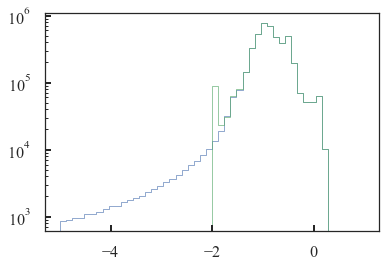

In [289]:
plt.hist(np.log10(joint_table['log10_age_err']),range=[-5.,1.],histtype='step',bins=50);
plt.hist(np.log10(np.sqrt(0.01**2+joint_table['log10_age_err']**2)),range=[-5.,1.],histtype='step',bins=50);
plt.semilogy()

/home/jls/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


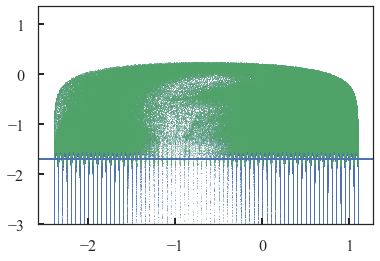

In [291]:
plt.plot(joint_table['log10_age'],np.log10(joint_table['log10_age_err']),'.',ms=1);
plt.plot(joint_table['log10_age'],np.log10(np.sqrt(0.015**2+joint_table['log10_age_err']**2)),'.',ms=1);
plt.ylim(-3.,)
plt.axhline(np.log10(0.02))

In [251]:
d2 = Table.read('/data/jls/GaiaDR2/spectro/SEGUE_distances_withPRIOR_parallax_fillin.hdf5')

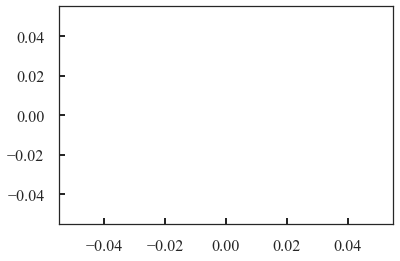

In [259]:
plt.plot(d2['log10_teff'][d2['flag']==3],
         d2['logg'][d2['flag']==3],'.')

In [301]:
print len(joint_table)
print len(rave)+len(raveON)+len(galah)+len(apogee)+len(segue)+len(ges)+len(lamost)

4906746
4906746


### Summarise properties

In [326]:
joint_table.meta['COMMENT']

['Distances, ages, masses and extinctions for spectroscopic surveys combined with Gaia DR2',
 'Isochrone set(s) used = PARSEC version 1.2S eta=0.2 http://stev.oapd.inaf.it/cgi-bin/cmd',
 'Adopted prior: 2018 prior described in Sanders et al. (2018)',
 'survey is a string giving the name of the survey the star was taken from -- APOGEE, GALAH, GES, RAVEON, RAVEDR5, LAMOST, SEGUE',
 'CNAME is the unique identifier for the GES survey',
 'sobject_id is the unique identifier for the GALAH survey',
 'APOGEE_ID is the unique identifier for the APOGEE survey',
 'raveid is the unique identifier for the RAVE Cannon survey',
 'raveid is the unique identifier for the RAVE DR5 survey',
 'obsid is the unique identifier for the LAMOST survey',
 'ra,dec are the equatorial coordinates from the spectroscopic surveys (in degrees) -- we use the spectroscopic survey ra,dec instead of Gaia ra,dec so cross-match failures with Gaia still have values.',
 'dm and dm_err give the distance modulus with associated 

In [327]:
surveys = ['Survey','RAVE','RAVEON','GALAH','APOGEE','LAMOST','GES','SEGUE','All','All no dupl.']
total_processed = ['Total', len(rave), len(raveON), len(galah), len(apogee), len(lamost), 
                   len(ges), len(segue), len(joint_table), np.count_nonzero(joint_table['duplicated']==0)]
matches = ['Gaia matches',np.count_nonzero(rave['source_id']>0.), 
           np.count_nonzero(raveON['source_id']>0.), 
           np.count_nonzero(galah['source_id']>0.), 
           np.count_nonzero(apogee['source_id']>0.), 
           np.count_nonzero(lamost['source_id']>0.), 
           np.count_nonzero(ges['source_id']>0.), 
           np.count_nonzero(segue['source_id']>0.), 
           np.count_nonzero(joint_table['source_id']>0.), np.count_nonzero(joint_table['duplicated']==0)]
successes = ['Success (0)',np.count_nonzero(rave['flag']==0), 
           np.count_nonzero(raveON['flag']==0), 
           np.count_nonzero(galah['flag']==0), 
           np.count_nonzero(apogee['flag']==0), 
           np.count_nonzero(lamost['flag']==0), 
           np.count_nonzero(ges['flag']==0),
           np.count_nonzero(segue['flag']==0),
            np.count_nonzero(joint_table['flag']==0), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==0))]

pipeline = ['Pipeline failed (1)',np.count_nonzero(rave['flag']==1), 
           np.count_nonzero(raveON['flag']==1), 
           np.count_nonzero(galah['flag']==1), 
           np.count_nonzero(apogee['flag']==1), 
           np.count_nonzero(lamost['flag']==1), 
           np.count_nonzero(ges['flag']==1),
           np.count_nonzero(segue['flag']==1),
            np.count_nonzero(joint_table['flag']==1), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==1))]

spec_problem = ['Spec. problem (2)',np.count_nonzero(rave['flag']==2), 
           np.count_nonzero(raveON['flag']==2), 
           np.count_nonzero(galah['flag']==2), 
           np.count_nonzero(apogee['flag']==2), 
           np.count_nonzero(lamost['flag']==2), 
           np.count_nonzero(ges['flag']==2),
           np.count_nonzero(segue['flag']==2),
            np.count_nonzero(joint_table['flag']==2), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==2))]

phot_problem = ['Phot. problem (3)',np.count_nonzero(rave['flag']==3), 
           np.count_nonzero(raveON['flag']==3), 
           np.count_nonzero(galah['flag']==3), 
           np.count_nonzero(apogee['flag']==3), 
           np.count_nonzero(lamost['flag']==3), 
           np.count_nonzero(ges['flag']==3), 
           np.count_nonzero(segue['flag']==3),
            np.count_nonzero(joint_table['flag']==3), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==3))]


unreliable_errors = ['Unreliable errors (6)',np.count_nonzero(rave['flag']==6), 
           np.count_nonzero(raveON['flag']==6), 
           np.count_nonzero(galah['flag']==6), 
           np.count_nonzero(apogee['flag']==6), 
           np.count_nonzero(lamost['flag']==6), 
           np.count_nonzero(ges['flag']==6),
           np.count_nonzero(segue['flag']==6),
            np.count_nonzero(joint_table['flag']==6), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==6))]

low_age = ['Low age (7)',np.count_nonzero(rave['flag']==7), 
           np.count_nonzero(raveON['flag']==7), 
           np.count_nonzero(galah['flag']==7), 
           np.count_nonzero(apogee['flag']==7), 
           np.count_nonzero(lamost['flag']==7), 
           np.count_nonzero(ges['flag']==7),
           np.count_nonzero(segue['flag']==7),
            np.count_nonzero(joint_table['flag']==7), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==7))]


successesG = ['Success with Gaia',np.count_nonzero((rave['flag']==0)&(rave['source_id']>0)), 
           np.count_nonzero((raveON['flag']==0)&(raveON['source_id']>0)), 
           np.count_nonzero((galah['flag']==0)&(galah['source_id']>0)), 
           np.count_nonzero((apogee['flag']==0)&(apogee['source_id']>0)), 
           np.count_nonzero((lamost['flag']==0)&(lamost['source_id']>0)), 
           np.count_nonzero((ges['flag']==0)&(ges['source_id']>0)), 
           np.count_nonzero((segue['flag']==0)&(segue['source_id']>0)), 
           np.count_nonzero((joint_table['flag']==0)&(joint_table['source_id']>0)), 
             np.count_nonzero((joint_table['duplicated']==0)&(joint_table['flag']==0))]
import tabulate
tab = tabulate.tabulate([surveys, total_processed, matches, 
                         successes, pipeline, spec_problem, phot_problem, 
                         unreliable_errors, low_age, successesG],tablefmt='latex')
with open('table.dat', 'w') as f:
    f.write(tab)

In [328]:
!head -20 table.dat

\begin{tabular}{llllllllll}
\hline
 Survey                & RAVE   & RAVEON & GALAH  & APOGEE & LAMOST  & GES   & SEGUE  & All     & All no dupl. \\
 Total                 & 457555 & 457555 & 342682 & 258475 & 3177995 & 25332 & 187152 & 4906746 & 3706733      \\
 Gaia matches          & 456353 & 456353 & 342212 & 256851 & 3168545 & 25313 & 187100 & 4892727 & 3706733      \\
 Success (0)           & 415200 & 376316 & 260233 & 203417 & 2859579 & 10882 & 182132 & 4307759 & 3316911      \\
 Pipeline failed (1)   & 1358   & 368    & 67     & 2778   & 27471   & 105   & 393    & 32540   & 26492        \\
 Spec. problem (2)     & 20602  & 67439  & 78455  & 42553  & 67452   & 12513 & 0      & 289014  & 185007       \\
 Phot. problem (3)     & 498    & 498    & 0      & 810    & 8124    & 1181  & 1490   & 12601   & 5012         \\
 Unreliable errors (6) & 3220   & 1093   & 46     & 460    & 7953    & 52    & 72     & 12896   & 6425         \\
 Low age (7)           & 16677  & 11841  & 3881   & 8

/home/jls/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jls/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


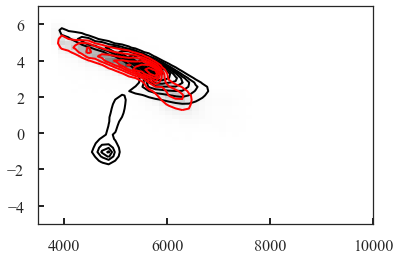

In [175]:
from matplotlib.colors import LogNorm
n=plt.hist2d(lamost_inputs['teff'][lamost['flag']==0],
           (lamost_inputs['J']-5.*np.log10(100./lamost_inputs['parallax']))[lamost['flag']==0],
           range=[[3500.,10000.],[-5.,7.]],bins=50);
plt.contour(.5*(n[1][1:]+n[1][:-1]),.5*(n[2][1:]+n[2][:-1]),n[0].T,colors='k')
n=plt.hist2d(lamost_inputs['teff'][lamost['flag']==7],
           (lamost_inputs['J']-5.*np.log10(100./lamost_inputs['parallax']))[lamost['flag']==7],
           range=[[3500.,10000.],[-5.,7.]],bins=50);
plt.contour(.5*(n[1][1:]+n[1][:-1]),.5*(n[2][1:]+n[2][:-1]),n[0].T,colors='r')

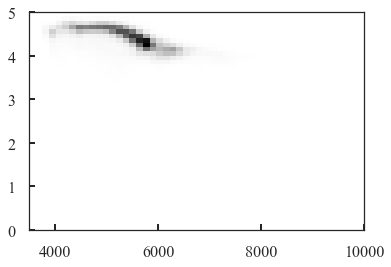

In [154]:
plt.hist2d(lamost_inputs['teff'][lamost['flag']==7],
           lamost_inputs['logg'][lamost['flag']==7],
           range=[[3500.,10000.],[0.,5.]],bins=50);

### Survey footprints

In [330]:
import matplotlib
import healpy as hp
def gen_fast_map_survey(data, i,nside=64):
    b = np.rad2deg(data['b'])
    l = np.rad2deg(data['l'])
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map_ = 1.*np.bincount(ip_,minlength=npixel)
    map_[map_>=1]=1
    map_[map_==0]=np.nan
#     cm=[plt.cm.Reds,
#         plt.cm.Blues,
#         plt.cm.Greens,
#         plt.cm.Purples][i]
    colors = [sns.color_palette()[4],
             sns.color_palette()[1],
             sns.color_palette()[3],
             sns.color_palette()[2],
             sns.color_palette()[0],
             sns.color_palette()[5]]
    alphas = [0.8,0.8,0.8,1.,1.,1.]
    colors=np.array([[colors[j][0],colors[j][1],colors[j][2],alphas[j]] for j in range(6)])
    cm = [matplotlib.colors.ListedColormap(([[0.,0.,0,0.0],
                                             colors[j]])) for j in range(6)][i]
    hp.visufunc.mollview(map_,fig=0,
                         title='',unit='',cmap=cm,cbar=False,min=0.,max=1.)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


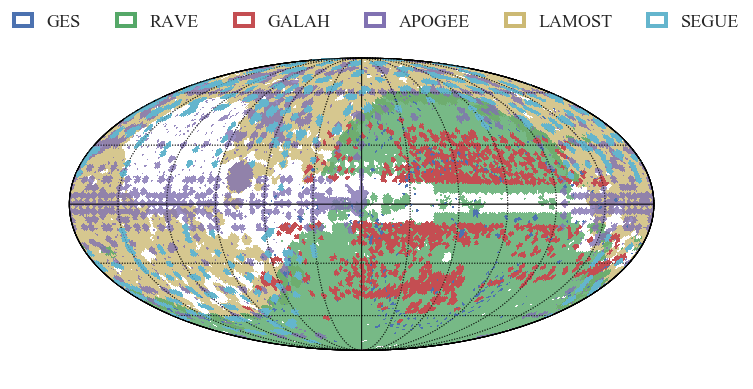

In [12]:
for i,a in enumerate([lamost,rave,apogee,galah,ges,segue]):
    gen_fast_map_survey(a,i)
hp.graticule(alpha=0.3)

from matplotlib.patches import Rectangle

handles = [Rectangle((0,0),1,1,color="none",ec=c,lw=4) for c in sns.color_palette()]
labels= ["GES","RAVE","GALAH","APOGEE","LAMOST","SEGUE"]
plt.legend(handles, labels, handlelength=1, ncol=6,bbox_to_anchor=(1.17,1.2))
plt.savefig('onsky.pdf',bbox_inches='tight')

### Binary stars

In [13]:
g = np.genfromtxt('/data/jls/isochrones/PARSEC_Gaia/grid/gaia_0.003.dat')
gJ = np.genfromtxt('/data/jls/isochrones/PARSEC_Gaia/grid/2mass_spitzer_wise_0.003.dat')
!head -15 /data/jls/isochrones/PARSEC_Gaia/grid/gaia_0.003.dat
!head -15 /data/jls/isochrones/PARSEC_Gaia/grid/2mass_spitzer_wise_0.003.dat

# File generated by CMD 3.0 (http://stev.oapd.inaf.it/cmd) on Mon Mar 19 16:49:29 CET 2018
# PARSEC isochrones, release v1.2S
# Basic references: Bressan et al. (2012), MNRAS, 427, 127 + Chen et al. (2014, 2015), MNRAS, 444, 2525 + MNRAS, 452, 1068 + Tang et al. (2014), MNRAS, 445, 4287
# Warning: you choose not to include the TP-AGB phase!
# Photometric system: Gaia's DR2 G, G_BP and G_RP (Vegamags)
# Using NBC version of bolometric corrections as in Chen et al. (2014), MNRAS, 444, 2525
# BCs of Carbon stars derive from Aringer et al. (2009, A&A 503, 913)
# O-rich circumstellar dpmod60alox40 dust from Groenewegen (2006)
# C-rich circumstellar AMCSIC15 dust from Groenewegen (2006)
# IMF: Chabrier (2001) lognormal 
# On RGB, assumed Reimers mass loss with efficiency eta=0.2
# Kind of output: isochrone tables
#	Isochrone  Z = 0.01479	Y = 0.27470	[M/H] = 0.003	eta_R = 0.200	Age = 	3.9811e+06 yr
#      Z	log(age/yr)	M_ini   	M_act	logL/Lo	logTe	logG	mbol    G       G_BP    G_RP	int_IMF	sta

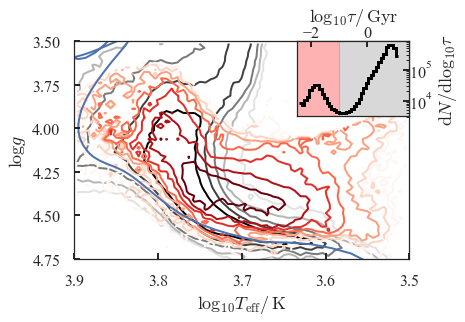

In [14]:
from matplotlib.colors import LogNorm
H=plt.hist2d(joint['log10_teff'][(joint['flag']==0)],
           joint['logg'][(joint['flag']==0)],
           bins=60,range=[[3.5,3.9],[3.5,5.]],
           norm=LogNorm(),
            );
H2=plt.hist2d(joint['log10_teff'][(joint['flag']==7)],
           joint['logg'][(joint['flag']==7)],
           bins=60,range=[[3.5,3.9],[3.5,5.]],
           norm=LogNorm(),
           cmap=plt.cm.viridis
          );
plt.clf()
plt.contour(.5*(H[1][1:]+H[1][:-1]),.5*(H[2][1:]+H[2][:-1]),np.log10(H[0]).T)
plt.contour(.5*(H2[1][1:]+H2[1][:-1]),.5*(H2[2][1:]+H2[2][:-1]),np.log10(H2[0]).T,cmap=plt.cm.Reds)
plt.xlim(3.9,3.5)
plt.ylim(4.75,3.5)
plt.xlabel(r'$\log_{10}T_\mathrm{eff}/\,\mathrm{K}$')
plt.ylabel(r'$\log g$')
plt.plot(g.T[5][g.T[1]==9.],g.T[6][g.T[1]==9.])
plt.axes([0.64,0.62,0.26,0.26])
plt.axvspan(-3,-1, alpha=0.3, color='red')
plt.axvspan(-1,2, alpha=0.3, color='gray')
plt.xlim(-2.5,1.5)

plt.hist(joint['log10_age'][(joint['flag']==0)|(joint['flag']==7)],histtype='step',lw=3,bins=40,color='k');
plt.xlabel(r'$\log_{10}\tau/\,\mathrm{Gyr}$')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log_{10}\tau$')
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()
plt.gca().xaxis.set_label_position('top') 
plt.gca().yaxis.set_label_position('right') 
plt.gca().tick_params(axis='both', which='major', pad=0)
plt.semilogy()
plt.savefig('age_binary.pdf', bbox_inches='tight')

In [15]:
from matplotlib.colors import LogNorm
H=plt.hist2d((jointinputs['J']-jointinputs['K'])[(joint['flag']==0)&(jointinputs['parallax_error']/jointinputs['parallax']<0.1)],
           (jointinputs['G']-5.*np.log10(100./jointinputs['parallax']))[(joint['flag']==0)&(jointinputs['parallax_error']/jointinputs['parallax']<0.1)],
           bins=60,range=[[0.,1.5],[3.,8.]],
#            norm=LogNorm(),
            );
H2=plt.hist2d((jointinputs['J']-jointinputs['K'])[(joint['flag']==7)&(jointinputs['parallax_error']/jointinputs['parallax']<0.1)],
           (jointinputs['G']-5.*np.log10(100./jointinputs['parallax']))[(joint['flag']==7)&(jointinputs['parallax_error']/jointinputs['parallax']<0.1)],
           bins=60,range=[[0.,1.5],[3.,8.]],
#            norm=LogNorm(),
            );
plt.clf()
plt.contour(.5*(H[1][1:]+H[1][:-1]),.5*(H[2][1:]+H[2][:-1]),H[0].T)#np.log10(H[0]).T)
plt.contour(.5*(H2[1][1:]+H2[1][:-1]),.5*(H2[2][1:]+H2[2][:-1]),H2[0].T,cmap=plt.cm.Reds)#np.log10(H2[0]).T,cmap=plt.cm.Reds)
plt.xlim(0.2,1.)
plt.ylim(7.5,3.)
# plt.xlabel(r'$\log_{10}T_\mathrm{eff}/\,\mathrm{K}$')
# plt.ylabel(r'$\log g$')
g= np.genfromtxt('/data/jls/isochrones/PARSEC_Gaia/grid/gaia_0.588.dat')
g2= np.genfromtxt('/data/jls/isochrones/PARSEC_Gaia/grid/2mass_spitzer_wise_0.588.dat')

plt.plot((g2.T[8]-g2.T[10])[g.T[1]==9.],g.T[8][g.T[1]==9.])
plt.axes([0.64,0.62,0.26,0.26])
plt.axvspan(-3,-1, alpha=0.3, color='red')
plt.axvspan(-1,2, alpha=0.3, color='gray')
plt.xlim(-2.5,1.5)

plt.hist(joint['log10_age'][(joint['flag']==0)|(joint['flag']==7)],histtype='step',lw=3,bins=40,color='k');
plt.xlabel(r'$\log_{10}\tau/\,\mathrm{Gyr}$')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log_{10}\tau$')
plt.gca().xaxis.tick_top()
plt.gca().yaxis.tick_right()
plt.gca().xaxis.set_label_position('top') 
plt.gca().yaxis.set_label_position('right') 
plt.gca().tick_params(axis='both', which='major', pad=0)
plt.semilogy()
# plt.savefig('age_binary.pdf', bbox_inches='tight')

ValueError: cannot reindex from a duplicate axis

### Input/Output teff,logg,Z

In [41]:
plt.hexbin?

In [142]:
def input_output(inputs, data, a, title, axis_labels=False):
    fltr = data['flag']==0
    fltr &= data['log10_age']>-1.
    plt.sca(a[0])
#     plt.scatter(np.log10(inputs['teff'][fltr]),inputs['logg'][fltr],
#                 c=inputs['fe_h'][fltr],s=1,cmap=plt.cm.viridis, 
#                 alpha=0.2, vmin=-2., vmax=0.5);
    
    plt.hexbin(np.log10(inputs['teff'][fltr]),inputs['logg'][fltr],
                C=inputs['fe_h'][fltr],cmap=plt.cm.viridis, extent=[3.5,4.,-0.5,5.5],
                vmin=-2., vmax=0.5, gridsize=100, mincnt=2);
    n,x,y = np.histogram2d(np.log10(inputs['teff'][fltr]),inputs['logg'][fltr], 
                           range=[[3.5,4.],[-0.5,5.]],bins=50)
    x, y = .5*(x[1:]+x[:-1]), .5*(y[1:]+y[:-1])
    plt.contour(x,y,np.sqrt(n.T),4,colors='k',alpha=0.4)
    
    if axis_labels:
        plt.xlabel(r'$\log_{10}T_\mathrm{eff}$')
        plt.ylabel(r'$\log g$')
    else:
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
    plt.annotate(title,xy=(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize=16)

    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.xlim(4.,3.5)
    plt.ylim(5.5,-0.5)
    plt.sca(a[1])
#     plt.scatter(data['log10_teff'][fltr],data['logg'][fltr],c=data['Z'][fltr],s=1,
#                 cmap=plt.cm.viridis, alpha=0.2, vmin=-2., vmax=0.5);
    c = plt.hexbin(data['log10_teff'][fltr],data['logg'][fltr],
            C=data['Z'][fltr],cmap=plt.cm.viridis, extent=[3.5,4.,-0.5,5.5],
            vmin=-2., vmax=0.5, gridsize=100, mincnt=2);
    n,x,y = np.histogram2d(data['log10_teff'][fltr],data['logg'][fltr], 
                           range=[[3.5,4.],[-0.5,5.]],bins=50)
    x, y = .5*(x[1:]+x[:-1]), .5*(y[1:]+y[:-1])
    plt.contour(x,y,np.sqrt(n.T),4,colors='k',alpha=0.4)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlim(4.,3.5)
    plt.ylim(5.5,-0.5)
    return c

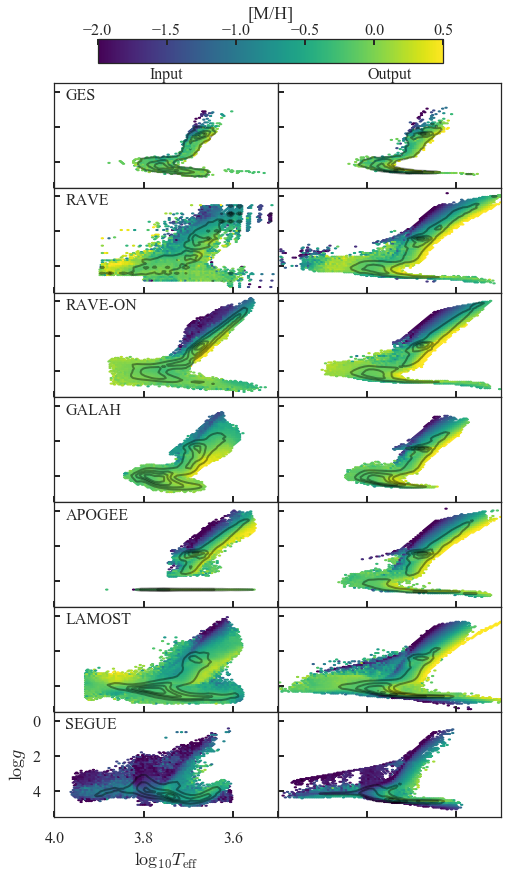

In [144]:
f,a=plt.subplots(7,2,figsize=[8.,13.5])
plt.subplots_adjust(wspace=0.,hspace=0.)
plt.sca(a[0][0]);plt.gca().annotate('Input',(0.5,1.),
                                    fontsize=16,xycoords='axes fraction',ha='center',va='bottom')
plt.sca(a[0][1]);plt.gca().annotate('Output',(0.5,1.),
                                    fontsize=16,xycoords='axes fraction',ha='center',va='bottom')
input_output(ges_inputs, ges, a[0], 'GES')
input_output(rave_inputs, rave, a[1], 'RAVE')
input_output(raveON_inputs, raveON, a[2], 'RAVE-ON')
input_output(galah_inputs, galah, a[3], 'GALAH')
input_output(apogee_inputs, apogee, a[4], 'APOGEE')
input_output(lamost_inputs, lamost, a[5], 'LAMOST')
c = input_output(segue_inputs, segue, a[6], 'SEGUE', axis_labels=True)
cb_ax = f.add_axes([0.2, 0.9, 0.6, 0.025])
cbar = f.colorbar(c, cax=cb_ax, label='[M/H]', orientation='horizontal')
cbar.ax.xaxis.set_tick_params(pad=0.)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
# plt.tight_layout()
plt.savefig('hr_diagrams_hex.png',dpi=200,bbox_inches='tight')

In [382]:
def giants(d):
    return (d['logg']<3.)&(d['log10_teff']<3.73)
def turnoff(d):
    return (d['logg']<4.5)&(d['logg']>3.6)&(d['log10_teff']<4.1)
def hq_age(d):
    return (d['log10_age']>-1)&(d['log10_age_err']*np.log(10.)<0.3)

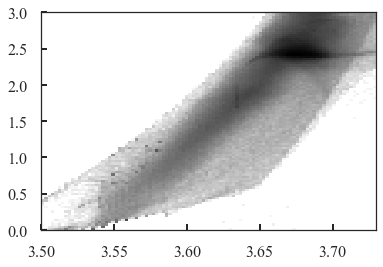

In [47]:
from matplotlib.colors import LogNorm
plt.hist2d(joint_table['log10_teff'],joint_table['logg'],range=[[3.5,3.73],[0.,3.]],bins=100,norm=LogNorm());

(0.0, 5.0)

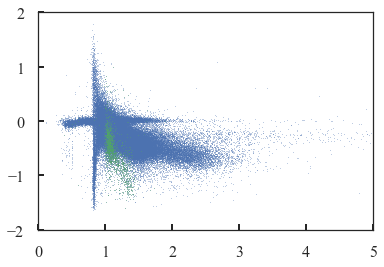

In [92]:
plt.plot(apogee['mass'][(apogee['flag']==0)],
         apogee_inputs['C_N'][(apogee['flag']==0)],'.',ms=1)
plt.plot(apogee['mass'][(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<.8)&(apogee['log10_age']>0.)],
         apogee_inputs['C_N'][(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<.8)&(apogee['log10_age']>0.)],'.',ms=1)
plt.ylim(-2.,2.)
plt.xlim(0.,5.)

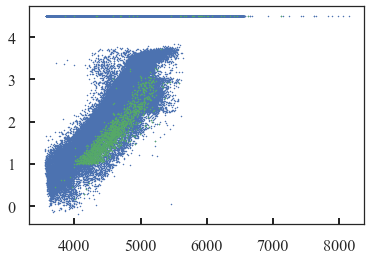

In [82]:
plt.plot(apogee_inputs['teff'][(apogee['flag']==0)],
         apogee_inputs['logg'][(apogee['flag']==0)],'.',ms=3)
plt.plot(apogee_inputs['teff'][(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<.8)&(apogee['log10_age']>0.)],
         apogee_inputs['logg'][(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<.8)&(apogee['log10_age']>0.)],'.',ms=3)

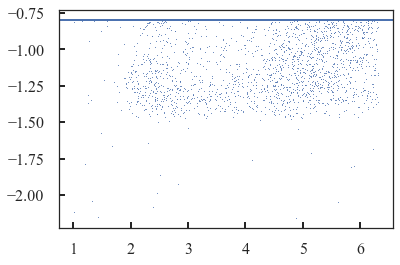

In [75]:
plt.plot(np.power(10.,apogee['log10_age'])[(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<.8)&(apogee['log10_age']>0.)],
         apogee['Z'][(apogee['flag']==0)&(apogee['Z']<-0.8)&(apogee['log10_age']<0.8)&(apogee['log10_age']>0.)],'.',ms=2)
plt.axhline(-0.8)

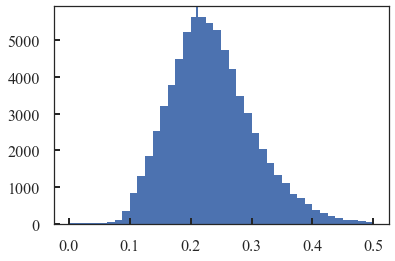

In [510]:
plt.hist(galah['log10_age_err'][giants(galah)]*np.log(10.),range=[0.,0.5],bins=40);
plt.axvline(0.21)

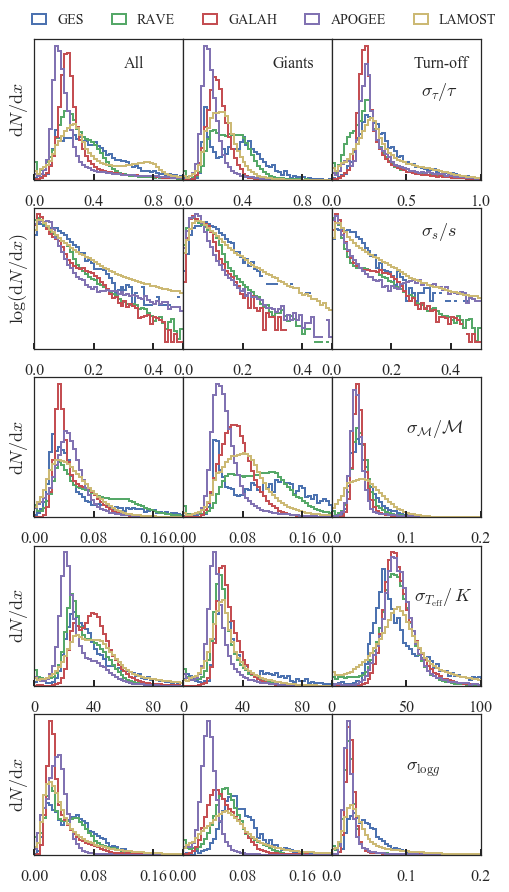

In [19]:
from matplotlib.ticker import MaxNLocator
f,a=plt.subplots(5,3,figsize=[8,15.])
plt.sca(a[0][0])
plt.subplots_adjust(wspace=0.)
[plt.hist(s['log10_age_err'][(s['log10_age']>-.1)&(s['flag']==0)]*np.log(10.),bins=50,
          histtype='step',range=[0.,1.],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
plt.legend(loc='lower left',bbox_to_anchor=(-0.1,1.), ncol=5, handlelength=1, fontsize=14)
plt.annotate('All', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)

plt.sca(a[0][1])
plt.annotate('Giants', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist(s['log10_age_err'][((s['log10_age']>-.1)&(s['flag']==0))&giants(s)]*np.log(10.),bins=50,
          histtype='step',range=[0.,1.],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.legend()
plt.sca(a[0][2])
plt.annotate('Turn-off', xy=(0.55,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist(s['log10_age_err'][((s['log10_age']>-.1)&(s['flag']==0))&turnoff(s)]*np.log(10.),bins=50,
          histtype='step',range=[0.,1.],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
plt.annotate(r'$\sigma_\tau/\tau$', xy=(0.6,0.6), xycoords='axes fraction', fontsize=18)

plt.sca(a[1][0])
plt.subplots_adjust(wspace=0.)
[plt.hist((s['dist_err']/s['dist'])[(s['log10_age']>-.1)&(s['flag']==0)],bins=50,
          histtype='step',range=[0.,0.5],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_d/d$')
plt.semilogy()

# plt.legend()
plt.sca(a[1][1])
[plt.hist((s['dist_err']/s['dist'])[((s['log10_age']>-.1)&(s['flag']==0))&giants(s)],bins=50,
          histtype='step',range=[0.,0.5],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_d/d$')
plt.semilogy()
# plt.legend()
plt.sca(a[1][2])
[plt.hist((s['dist_err']/s['dist'])[((s['log10_age']>-.1)&(s['flag']==0))&turnoff(s)],bins=50,
          histtype='step',range=[0.,0.5],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_d/d$')
plt.annotate(r'$\sigma_s/s$', xy=(0.6,0.8), xycoords='axes fraction', fontsize=18)
plt.semilogy()

plt.sca(a[2][0])
[plt.hist((s['mass_err']/s['mass'])[(s['log10_age']>-.1)&(s['flag']==0)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.annotate('All', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)

plt.sca(a[2][1])
# plt.annotate('Giants', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['mass_err']/s['mass'])[((s['log10_age']>-.1)&(s['flag']==0))&giants(s)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.legend()
plt.sca(a[2][2])
# plt.annotate('Turn-off', xy=(0.55,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['mass_err']/s['mass'])[((s['log10_age']>-.1)&(s['flag']==0))&turnoff(s)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
plt.annotate(r'$\sigma_\mathcal{M}/\mathcal{M}$', xy=(0.5,0.6), xycoords='axes fraction', fontsize=18)

plt.sca(a[3][0])
[plt.hist((s['log10_teff_err']*np.log(10.)*np.power(10.,s['log10_teff']))[(s['log10_age']>-.1)&(s['flag']==0)],bins=50,
          histtype='step',range=[0.,100],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.annotate('All', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)

plt.sca(a[3][1])
# plt.annotate('Giants', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['log10_teff_err']*np.log(10.)*np.power(10.,s['log10_teff']))[((s['log10_age']>-.1)&(s['flag']==0))&giants(s)],bins=50,
          histtype='step',range=[0.,100],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.legend()
plt.sca(a[3][2])
# plt.annotate('Turn-off', xy=(0.55,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['log10_teff_err']*np.log(10.)*np.power(10.,s['log10_teff']))[((s['log10_age']>-.1)&(s['flag']==0))&turnoff(s)],bins=50,
          histtype='step',range=[0.,100],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
plt.annotate(r'$\sigma_{T_\mathrm{eff}}/\,K$', xy=(0.55,0.6), xycoords='axes fraction', fontsize=18)

plt.sca(a[4][0])
[plt.hist((s['logg_err'])[(s['log10_age']>-.1)&(s['flag']==0)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.annotate('All', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)

plt.sca(a[4][1])
# plt.annotate('Giants', xy=(0.6,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['logg_err'])[((s['log10_age']>-.1)&(s['flag']==0))&giants(s)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
# plt.xlabel(r'$\sigma_\tau/\tau$')
# plt.legend()
plt.sca(a[4][2])
# plt.annotate('Turn-off', xy=(0.55,0.8), xycoords='axes fraction', fontsize=16)
[plt.hist((s['logg_err'])[((s['log10_age']>-.1)&(s['flag']==0))&turnoff(s)],bins=50,
          histtype='step',range=[0.,0.2],lw=2,normed=True,label=l) 
         for s,l in zip([ges, rave, galah, apogee, lamost],['GES','RAVE','GALAH','APOGEE','LAMOST'])];
plt.annotate(r'$\sigma_{\log g}$', xy=(0.5,0.6), xycoords='axes fraction', fontsize=18)

for i in range(3):
    a[0][i].set_xlim(0.,1.)
    a[1][i].set_xlim(0.,0.5)
    a[2][i].set_xlim(0.,0.2)
    a[3][i].set_xlim(0.,100)
    a[4][i].set_xlim(0.,0.2)
for i in range(5):
    a[i][0].set_ylabel(r'$\mathrm{d}N/\mathrm{d}x$')
    for j in range(3):
        a[i][j].axes.get_yaxis().set_ticks([])
    for j in range(2):
        a[i][j].xaxis.set_major_locator(MaxNLocator(nbins=3))
a[1][0].set_ylabel(r'$\log(\mathrm{d}N/\mathrm{d}x)$')
# plt.legend()
plt.savefig('uncertainties.pdf', bbox_inches='tight')

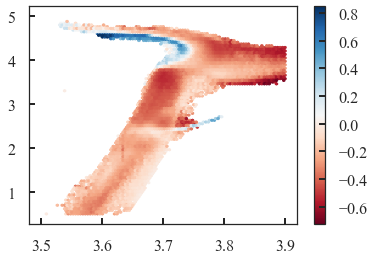

In [389]:
plt.hexbin(joint_table[joint_table['best']==1]['log10_teff'],
          joint_table[joint_table['best']==1]['logg'],
          C=joint_table[joint_table['best']==1]['log10age_Z_corr'],cmap=plt.cm.RdBu,
          extent=[3.5,3.9,0.5,5.],mincnt=20)
plt.colorbar()

# On-sky maps

In [344]:
import healpy as hp
def gen_fast_map(data, nside=64, bin_edges=[0.,0.],label='', title=None):
    b = np.rad2deg(data.b)
    l = np.rad2deg(data.l)
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
    map = np.log10(map_+1.)
    if title is None:
        title='%0.2f,%0.2f'%(bin_edges[0],bin_edges[1])
    hp.visufunc.mollview(map,hold=True,title=title,unit=label)

def gen_fast_map_fld(data, fld, nside=64, vmin=None, vmax=None, 
                     bin_edges=[0.,0.],cmap=plt.cm.viridis,label='',rot=None, title=None, mincnt=10):
    cmap.set_under('white')
    b = np.rad2deg(data.b)
    l = np.rad2deg(data.l)
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    fldd=data[fld][fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map = np.array([np.nanmedian(fldd[ip_==i]) for i in range(npixel)])
    cnt_ = np.bincount(ip_,minlength=npixel)
    map[cnt_<mincnt]=np.nan
    if title is None:
        title='%0.2f,%0.2f'%(bin_edges[0],bin_edges[1])
    hp.visufunc.mollview(map,hold=True,min=vmin,max=vmax,
                    title=title,cmap=cmap,unit='',rot=rot)
    plt.annotate(label,xy=(0.5,-0.2),xycoords='axes fraction',fontsize=20,ha='center',va='top')
    
    
def gen_fast_map_fld_DIFF(data, data2, fld, nside=64, vmin=None, vmax=None, 
                     bin_edges=[0.,0.],cmap=plt.cm.viridis,label='',rot=None, title=None, mincnt=10,
                         log_scl=False):
    cmap.set_under('white')
    
    b = np.rad2deg(data.b)
    l = np.rad2deg(data.l)
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    fldd=data[fld][fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map = np.array([np.nanmedian(fldd[ip_==i]) for i in range(npixel)])
    cnt_ = np.bincount(ip_,minlength=npixel)
    map[cnt_<mincnt]=np.nan
    
    b = np.rad2deg(data2.b)
    l = np.rad2deg(data2.l)
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    fldd=data2[fld][fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map2 = np.array([np.nanmedian(fldd[ip_==i]) for i in range(npixel)])
    cnt_ = np.bincount(ip_,minlength=npixel)
    map2[cnt_<mincnt]=np.nan
    
    if title is None:
        title='%0.2f,%0.2f'%(bin_edges[0],bin_edges[1])
    deltamap=map2-map
    if log_scl:
        deltamap=np.log10(np.abs(deltamap))
    hp.visufunc.mollview(deltamap,hold=True,min=vmin,max=vmax,
                    title=title,cmap=cmap,unit='',rot=rot)
    plt.annotate(label,xy=(0.5,-0.2),xycoords='axes fraction',fontsize=20,ha='center',va='top')
    
    
def gen_fast_map_fld_radec(data, fld, nside=64, vmin=None, vmax=None, 
                     bin_edges=[0.,0.],cmap=plt.cm.viridis,label='',rot=None, title=None, mincnt=10):
    cmap.set_under('white')
    b = data.dec
    l = data.ra
    fltr = (b>-90.)&(b<90.)
    l=l[fltr]
    b=b[fltr]
    fldd=data[fld][fltr]
    ip_ = hp.ang2pix(nside, l, b, lonlat=True)
    npixel  = hp.nside2npix(nside)
    map = np.array([np.nanmedian(fldd[ip_==i]) for i in range(npixel)])
    cnt_ = np.bincount(ip_,minlength=npixel)
    map[cnt_<mincnt]=np.nan
    if title is None:
        title='%0.2f,%0.2f'%(bin_edges[0],bin_edges[1])
    hp.visufunc.mollview(map,hold=True,min=vmin,max=vmax,
                    title=title,cmap=cmap,unit='',rot=rot)
    plt.annotate(label,xy=(0.5,-0.2),xycoords='axes fraction',fontsize=20,ha='center',va='top')

In [21]:
P = joint_table.to_pandas().reset_index(drop=True)
P = P[P['best']==1][['l','b','age','log10_age_err','logg','log10_teff','log10_av','s','Z','z','R']]

/home/jls/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


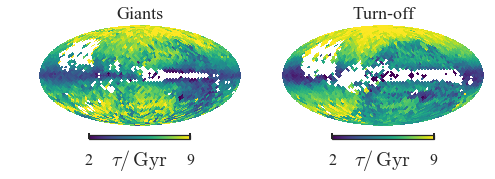

In [22]:
from matplotlib.colors import LogNorm
f,a=plt.subplots(1,2,figsize=[8.,3.])
plt.sca(a[0])
gen_fast_map_fld(P[giants(P)], 'age',nside=16,vmin=2.,vmax=9., label=r'$\tau/\,\mathrm{Gyr}$', title='Giants')
plt.sca(a[1])
gen_fast_map_fld(P[turnoff(P)], 'age',nside=16,vmin=2.,vmax=9., label=r'$\tau/\,\mathrm{Gyr}$', title='Turn-off')
plt.savefig('age_distribution.pdf', bbox_inches='tight')

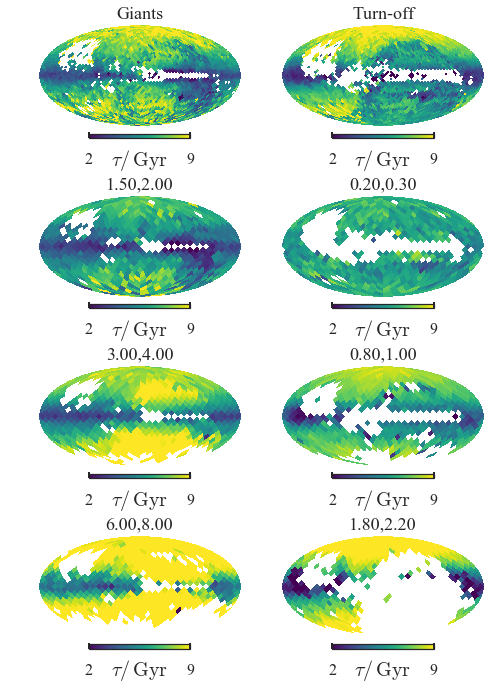

In [23]:
f,a=plt.subplots(4,2,figsize=[8.,12.])
plt.sca(a[0][0])
gen_fast_map_fld(P[giants(P)], 'age',nside=16,vmin=2.,vmax=9., label=r'$\tau/\,\mathrm{Gyr}$', title='Giants')
plt.sca(a[1][0])
gen_fast_map_fld(P[giants(P)&(P['s']>1.5)&(P['s']<2.)],
                 'age',nside=8,vmin=2.,vmax=9.,bin_edges=[1.5,2.], label=r'$\tau/\,\mathrm{Gyr}$')
plt.sca(a[2][0])
gen_fast_map_fld(P[giants(P)&(P['s']>3.)&(P['s']<4.)],
                 'age',nside=8,vmin=2.,vmax=9.,bin_edges=[3.,4.], label=r'$\tau/\,\mathrm{Gyr}$')
plt.sca(a[3][0])
gen_fast_map_fld(P[giants(P)&(P['s']>6.)&(P['s']<8.)],
                 'age',nside=8,vmin=2.,vmax=9.,bin_edges=[6.,8.], label=r'$\tau/\,\mathrm{Gyr}$')
plt.sca(a[0][1])
gen_fast_map_fld(P[turnoff(P)], 'age',nside=16,vmin=2.,vmax=9., label=r'$\tau/\,\mathrm{Gyr}$', title='Turn-off')
plt.sca(a[1][1])
gen_fast_map_fld(P[turnoff(P)&(P['s']>0.2)&(P['s']<0.3)],
                 'age',nside=8,vmin=2.,vmax=9.,mincnt=20,rot=0, label=r'$\tau/\,\mathrm{Gyr}$',bin_edges=[0.2,0.3])
plt.sca(a[2][1])
gen_fast_map_fld(P[turnoff(P)&(P['s']>0.8)&(P['s']<1.)],
                 'age',nside=8,vmin=2.,vmax=9.,mincnt=20,rot=0, label=r'$\tau/\,\mathrm{Gyr}$',bin_edges=[0.8,1.])
plt.sca(a[3][1])
gen_fast_map_fld(P[turnoff(P)&(P['s']>1.8)&(P['s']<2.2)],
                 'age',nside=8,vmin=2.,vmax=9.,mincnt=20,rot=0, label=r'$\tau/\,\mathrm{Gyr}$',bin_edges=[1.8,2.2])
plt.savefig('age_distribution_split.pdf', bbox_inches='tight')

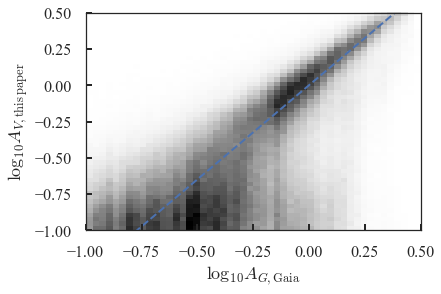

In [24]:
plt.hist2d(np.log10(jointinputs.a_g_val.values)[(joint['flag']==0)],
           joint['log10_av'][(joint['flag']==0)].astype(np.float64),
           range=[[-1.,0.5],[-1.,0.5]],bins=50);
xx = np.linspace(-1.,0.5)
plt.plot(xx,xx/0.77,label=r'$\frac{R(G)}{R(V)}=0.77$',ls='dashed')
plt.xlabel(r'$\log_{10}A_{G,\mathrm{Gaia}}$')
plt.ylabel(r'$\log_{10}A_{V,\mathrm{this\,paper}}$')
plt.savefig('extinction_ag_av.pdf', bbox_inches='tight')

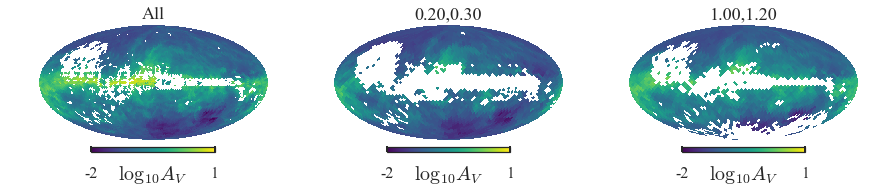

In [25]:
from matplotlib.colors import LogNorm
f,a=plt.subplots(1,3,figsize=[15.,2.5])
plt.sca(a[1])
gen_fast_map_fld(joint_table[(joint_table['best']==1)&(joint_table['s']<0.3)&(joint_table['s']>0.2)].to_pandas(),
                 'log10_av',nside=16,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[0.2,0.3])
plt.sca(a[2])
gen_fast_map_fld(joint_table[(joint_table['best']==1)&(joint_table['s']>1.)&(joint_table['s']<1.2)].to_pandas(),
                 'log10_av',nside=16,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[1.,1.2])
plt.sca(a[0])
gen_fast_map_fld(joint_table[(joint_table['best']==1)].to_pandas(),
                 'log10_av',nside=32,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[3.,3.5], title='All')
# plt.sca(a[2])
# plt.hist2d(np.log10(jointinputs.a_g_val)[(joint_table['best']==1)],
#            joint_table['log10_av'][(joint_table['best']==1)],range=[[-1.,0.5],[-1.,0.5]],bins=50);#,norm=LogNorm());
# xx = np.linspace(-1.,0.5)
# # plt.plot(xx,xx,label=r'$\frac{R(G)}{R(V)}=1$')
# plt.plot(xx,xx/0.77,label=r'$\frac{R(G)}{R(V)}=0.77$',ls='dashed')
# # plt.legend(loc='upper left')
# plt.xlabel(r'$\log_{10}A_{G,\mathrm{Gaia}}$')
# plt.ylabel(r'$\log_{10}A_{V,\mathrm{this\,paper}}$')
# plt.tight_layout()
plt.savefig('extinction.pdf',bbox_inches='tight')

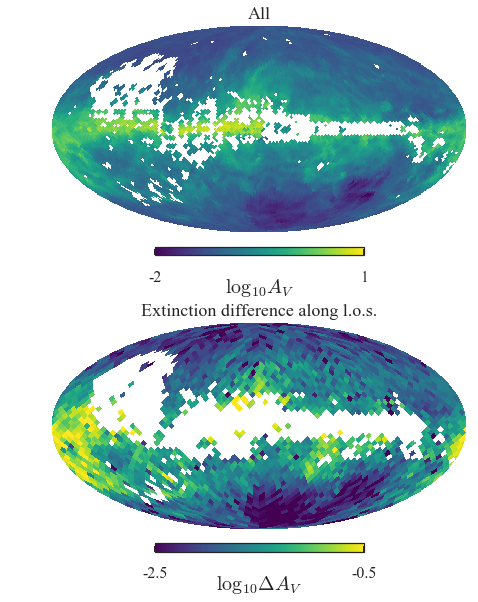

In [379]:
from matplotlib.colors import LogNorm
f,a=plt.subplots(2,1,figsize=[7.5,10])
# plt.sca(a[1])
# gen_fast_map_fld(joint_table[(joint_table['best']==1)&(joint_table['s']<0.3)&(joint_table['s']>0.2)].to_pandas(),
#                  'log10_av',nside=16,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[0.2,0.3])
# plt.sca(a[2])
# gen_fast_map_fld(joint_table[(joint_table['best']==1)&(joint_table['s']>1.)&(joint_table['s']<1.2)].to_pandas(),
#                  'log10_av',nside=16,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[1.,1.2])
plt.sca(a[1])
joint_table['av']=np.power(10.,joint_table['log10_av'])
gen_fast_map_fld_DIFF(
                      joint_table[(joint_table['best']==1)&(joint_table['s']<0.25)&(joint_table['s']>0.15)].to_pandas(),
                      joint_table[(joint_table['best']==1)&(joint_table['s']>0.25)&(joint_table['s']<0.35)].to_pandas(),
                 'av',nside=16,vmin=-2.5,vmax=-0.5,label=r'$\log_{10}\Delta A_V$',bin_edges=[1.,1.2],log_scl=True,
                mincnt=5,title='Extinction difference along l.o.s.')
plt.sca(a[0])
gen_fast_map_fld(joint_table[(joint_table['best']==1)].to_pandas(),
                 'log10_av',nside=32,vmin=-2.,vmax=1.,label=r'$\log_{10}A_V$',bin_edges=[3.,3.5], title='All')

plt.savefig('extinction_vertical.pdf',bbox_inches='tight')

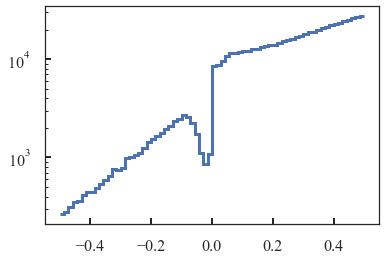

In [43]:
plt.hist(joint['par_err'].values[joint['flag']==0]/jointinputs['parallax_error'].values[joint['flag']==0],
         histtype='step',lw=3,bins=70,range=[-.5,.5]);
plt.semilogy();

(0.0, 3.0)

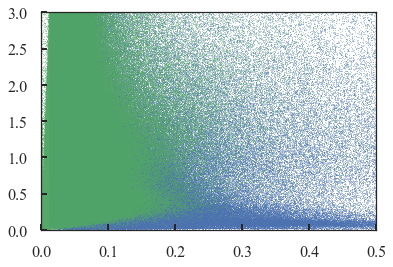

In [59]:
plt.plot(jointinputs['parallax_error'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],
        joint['par'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],'.',ms=1)
plt.plot(joint['par_err'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],
        joint['par'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],'.',ms=1)

plt.xlim(0.,0.5)
plt.ylim(0.,3.)

(0.0, 3.0)

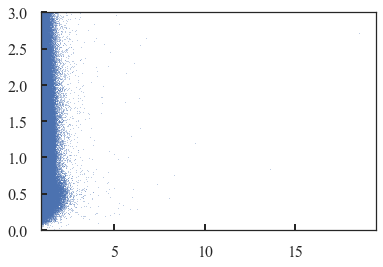

In [54]:
plt.plot(joint['par_err'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)]
         /jointinputs['parallax_error'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],
        joint['par'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],'.',ms=1)
plt.xlim(1.,)
plt.ylim(0.,3.)

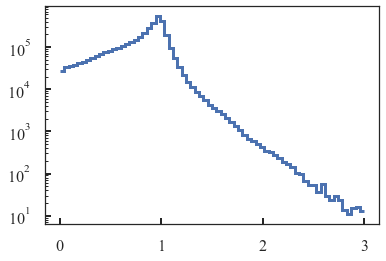

In [49]:
plt.hist(joint['par_err'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)]
         /jointinputs['parallax_error'].values[(joint['flag']==0)&(jointinputs['parallax_error'].values>0.)],
         histtype='step',lw=3,bins=70,range=[0.,3.]);

# plt.hist(joint['par_err'].values[joint['flag']!=0]-jointinputs['parallax_error'].values[joint['flag']!=0],
#          histtype='step',lw=3,bins=70,range=[-.5,.5]);
plt.semilogy();

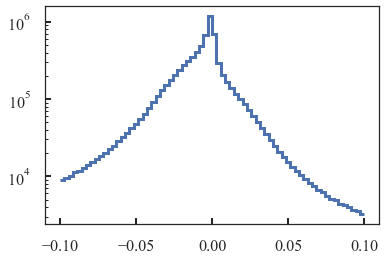

In [27]:
plt.hist(joint['par_err']-jointinputs['parallax_error'],
         histtype='step',lw=3,bins=70,range=[-.1,.1]);
plt.semilogy();

## Velocity dispersion, action dispersion

In [380]:
from scipy.optimize import leastsq, brentq
def mini(v,sig,s=None):
    if s is None:
        s = np.nanstd(v)
    m = np.nanmedian(v)
    v, sig = v[np.abs(v-m)<3.*s], sig[np.abs(v-m)<3.*s]
    def l(p):
        return np.sum((v-m)**2/(p**2+sig**2)**2-1./(p**2+sig**2))
    ll = l(s)
    s1 = .95*s
    while ll*l(s1)>0 and s1>5.:
        s1 *=0.95
    if s1<5.:
        return np.nan
    return brentq(l,s1,s,xtol=1e-2)

In [383]:
gg = joint_table[(joint_table['best']==1)&(joint_table['log10_age_err']<0.2)
                 &((turnoff(joint_table))|giants(joint_table))].to_pandas()
print len(gg)

1965012


In [384]:
print np.count_nonzero((np.abs(gg['z'])<0.6)&(gg['Z']>-1.))

1196449


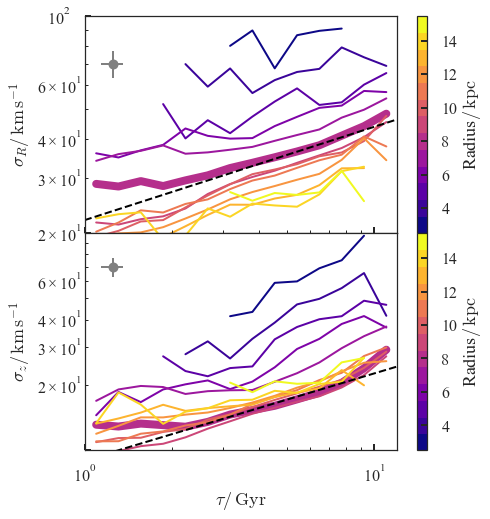

In [385]:
import matplotlib.cm as cmx
import matplotlib.colors as colors
from scipy.stats import gaussian_kde
import sys
sys.path.append('../../rave_cannon_distances/')
sys.path.append('../../rave_cannon_distances/veldisp_plots/')
from plotting_rave import *

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def get_scalarMap(vals):
#     cm = discrete_cmap(len(vals), base_cmap='plasma')
    cm = plt.cm.get_cmap('plasma',len(vals))
    cNorm=colors.Normalize(vmin=vals[0]-.5*(vals[1]-vals[0]),vmax=vals[-1]+.5*(vals[1]-vals[0]))
    sM = cmx.ScalarMappable(norm=cNorm,cmap=cm)
    sM._A=[]
    return sM

fig,ax = plt.subplots(2,1,figsize=[7.,8.])
plt.subplots_adjust(hspace=0.)
plt.sca(ax[0])

age_bins=np.logspace(np.log10(1.),np.log10(12.),15)
age_centroids=.5*(age_bins[1:]+age_bins[:-1])

Rbins = np.array([2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.])+.5
Rcentroids = .5*(Rbins[1:]+Rbins[:-1])
scalarMap = get_scalarMap(Rcentroids)
for r in range(len(Rbins)-1):
    dd = gg[(gg['R']>Rbins[r])&(gg['R']<Rbins[r+1])&(np.abs(gg['z'])<0.6)&(gg['Z']>-1.)]
    cnt = np.array([len(dd['vR'][(dd['age']>ad)&(dd['age']<au)].values) for ad,au in zip(age_bins[:-1],age_bins[1:])])
    err = np.array([mini(dd['vR'][(dd['age']>ad)&(dd['age']<au)].values,
                dd['vR_err'][(dd['age']>ad)&(dd['age']<au)].values,
                sigma_clip(dd['vR'][(dd['age']>ad)&(dd['age']<au)].values).clipped.std()) 
           for ad,au in zip(age_bins[:-1],age_bins[1:])])
    lw = 2
    if .5*(Rbins[r]+Rbins[r+1])==8.:
        lw=8
    plt.plot(age_centroids[cnt>50],err[cnt>50],color=scalarMap.to_rgba(.5*(Rbins[r]+Rbins[r+1])),lw=lw)

plt.semilogy()
plt.semilogx()
plt.ylim(20.,100.)
plt.xlim(1.,12.)
xx = np.linspace(1.,12.)
plt.plot(xx,22.*xx**0.3,color='k',ls='dashed')
plt.colorbar(scalarMap,label='Radius$ /\,\mathrm{kpc}$')
plt.xlabel(r'$\tau/\,\mathrm{Gyr}$')
plt.ylabel(r'$\sigma_R/\,\mathrm{km\,s}^{-1}$')
plt.errorbar([1.25],[70.],xerr=np.array([[1.25-np.exp(-(np.log(age_bins[2])-np.log(age_bins[1]))*.5+np.log(1.25)),
                                np.exp((np.log(age_bins[2])-np.log(age_bins[1]))*.5+np.log(1.25))-1.25]]),
             yerr=[70.*np.sqrt(1./2./50.)],color='gray',fmt='o',ms=10)
plt.gca().set_xticklabels([])
plt.sca(ax[1])

Rbins = np.array([2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.])+.5
Rcentroids = .5*(Rbins[1:]+Rbins[:-1])
scalarMap = get_scalarMap(Rcentroids)
for r in range(len(Rbins)-1):
    dd = gg[(gg['R']>Rbins[r])&(gg['R']<Rbins[r+1])&(np.abs(gg['z'])<0.6)&(gg['Z']>-1.)]
    cnt = np.array([len(dd['vz'][(dd['age']>ad)&(dd['age']<au)].values) for ad,au in zip(age_bins[:-1],age_bins[1:])])
    err = np.array([mini(dd['vz'][(dd['age']>ad)&(dd['age']<au)].values,
                dd['vz_err'][(dd['age']>ad)&(dd['age']<au)].values,
                sigma_clip(dd['vz'][(dd['age']>ad)&(dd['age']<au)].values).clipped.std()) 
           for ad,au in zip(age_bins[:-1],age_bins[1:])])
    lw = 2
    if .5*(Rbins[r]+Rbins[r+1])==8.:
        lw=8
    plt.plot(age_centroids[cnt>50],err[cnt>50],color=scalarMap.to_rgba(.5*(Rbins[r]+Rbins[r+1])),lw=lw)
plt.gca().set_yticklabels([])
plt.semilogy()
plt.semilogx()
plt.ylim(10.,100.)
plt.xlim(1.,12.)
xx = np.linspace(1.,12.)
plt.plot(xx,9.*xx**0.4,color='k',ls='dashed')
plt.gca().set_yticklabels(plt.gca().get_yticklabels()[:-2])
plt.colorbar(scalarMap,label='Radius$ /\,\mathrm{kpc}$')
plt.xlabel(r'$\tau/\,\mathrm{Gyr}$')
plt.ylabel(r'$\sigma_z/\,\mathrm{km\,s}^{-1}$')

plt.errorbar([1.25],[70.],xerr=np.array([[1.25-np.exp(-(np.log(age_bins[2])-np.log(age_bins[1]))*.5+np.log(1.25)),
                                np.exp((np.log(age_bins[2])-np.log(age_bins[1]))*.5+np.log(1.25))-1.25]]),
             yerr=[70.*np.sqrt(1./2./50.)],color='gray',fmt='o',ms=10)

plt.savefig('sigma_age.pdf', bbox_inches='tight')

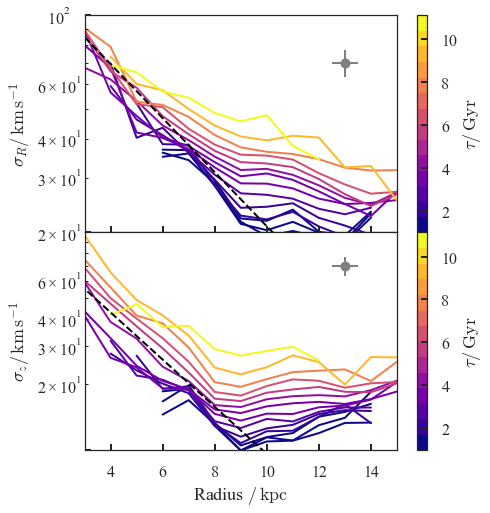

In [386]:
fig,ax = plt.subplots(2,1,figsize=[7.,8.])
plt.subplots_adjust(hspace=0.)
plt.sca(ax[0])

age_bins=np.logspace(np.log10(1.),np.log10(12.),15)

Rbins = np.array([2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.])+.5
Rcentroids = .5*(Rbins[1:]+Rbins[:-1])
scalarMap = get_scalarMap(age_centroids)
for ad,au in zip(age_bins[:-1],age_bins[1:]):
    dd = gg[(gg['age']>ad)&(gg['age']<au)&(np.abs(gg['z'])<0.6)&(gg['Z']>-1.)]
    cnt = np.array([len(dd['vR'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values)
                   for r in range(len(Rbins)-1)])
    err = np.array([mini(dd['vR'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values,
                dd['vR_err'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values,
                sigma_clip(dd['vR'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values).clipped.std()) 
           for r in range(len(Rbins)-1)])
    lw = 2
    plt.plot(Rcentroids[cnt>50],err[cnt>50],color=scalarMap.to_rgba(.5*(au+ad)),lw=lw)
plt.gca().set_xticklabels([])
plt.semilogy()
# plt.semilogx()
plt.ylim(20.,100.)
plt.xlim(3.,15.)
xx = np.linspace(1.,12.)
plt.plot(xx,np.exp(-(xx-8.2)/5.)*30.,color='k',ls='dashed')
plt.colorbar(scalarMap,label=r'$\tau/\,\mathrm{Gyr}$')
# plt.xlabel(r'Radius $/\,\mathrm{kpc}$')
plt.errorbar([13.],[70.],xerr=[.5],
             yerr=[70.*np.sqrt(1./2./50.)],color='gray',fmt='o',ms=10)
plt.ylabel(r'$\sigma_R/\,\mathrm{km\,s}^{-1}$')
plt.sca(ax[1])

Rbins = np.array([2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.])+.5
Rcentroids = .5*(Rbins[1:]+Rbins[:-1])
scalarMap = get_scalarMap(age_centroids)
for ad,au in zip(age_bins[:-1],age_bins[1:]):
    dd = gg[(gg['age']>ad)&(gg['age']<au)&(np.abs(gg['z'])<0.6)&(gg['Z']>-1.)]
    cnt = np.array([len(dd['vz'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values)
                   for r in range(len(Rbins)-1)])
    err = np.array([mini(dd['vz'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values,
                dd['vz_err'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values,
                sigma_clip(dd['vz'][(dd['R']>Rbins[r])&(dd['R']<Rbins[r+1])].values).clipped.std()) 
           for r in range(len(Rbins)-1)])
    lw = 2
    plt.plot(Rcentroids[cnt>50],err[cnt>50],color=scalarMap.to_rgba(.5*(au+ad)),lw=lw)
plt.gca().set_yticklabels([])
plt.semilogy()
# plt.semilogx()
plt.ylim(10.,100.)
plt.xlim(3.,15.)
xx = np.linspace(1.,12.)
plt.plot(xx,np.exp(-(xx-8.2)/4.)*15.,color='k',ls='dashed')
plt.colorbar(scalarMap,label=r'$\tau/\,\mathrm{Gyr}$')
plt.gca().set_yticklabels(plt.gca().get_yticklabels()[:-2])
plt.xlabel(r'Radius $/\,\mathrm{kpc}$')
plt.ylabel(r'$\sigma_z/\,\mathrm{km\,s}^{-1}$')
plt.errorbar([13.],[70.],xerr=[.5],yerr=[70.*np.sqrt(1./2./50.)],color='gray',fmt='o',ms=10)
plt.savefig('sigma_radius.pdf',bbox_inches='tight')

In [32]:
def plot_distributions(data,ax,compt='vR',sort_col='age',bins=50,range=[-150.,150.],cbar=False,label=None,
                      xlabel=None,agebins=10):
    data = data.copy()
    age_bins=np.linspace(0.,12.,agebins)
    age_centroids=.5*(age_bins[1:]+age_bins[:-1])
    scalarMap = get_scalarMap(age_centroids)
    nmax=0.
    for ad,au in zip(age_bins[:-1],age_bins[1:]):
        datasl = data[(data[sort_col]<au)&(data[sort_col]>ad)].reset_index(drop=True)
        datasl = datasl[datasl[compt].values==datasl[compt].values].reset_index(drop=True)
        dd = datasl[compt][(datasl[compt]>range[0])&(datasl[compt]<range[1])].values
        sns.kdeplot(dd,
                      lw=3,
                      color=scalarMap.to_rgba(.5*(ad+au)),ax=ax)
        ax.set_xlim(*range)
    if compt=='phi':
        compt=r'\phi'
    if(xlabel):
        ax.set_xlabel(r'$v_{%s}/\mathrm{km\,s}^{-1}$'%compt)
    if(cbar):
        plt.colorbar(scalarMap,boundaries=age_bins,label=r'$\tau/\mathrm{Gyr}$')
    if(label):
        ax.annotate(label,xy=(0.05,0.95),xycoords='axes fraction',fontsize=14,ha='left',va='top')
    return scalarMap

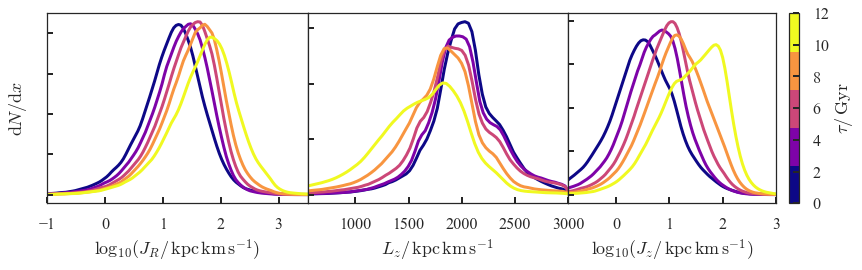

In [99]:
f,a=plt.subplots(1,3,figsize=[14.,3.5])
plt.subplots_adjust(wspace=0.)
gg['log10_JR']=np.log10(gg['JR'])
sM=plot_distributions(gg[(np.abs(gg['z'])<2.5)&(gg['Z']>-1.)],a[0],
                      compt='log10_JR',range=[-1.,4.],agebins=6)
sM=plot_distributions(gg[(np.abs(gg['z'])<2.5)&(gg['Z']>-1.)],a[1],
                      compt='Lz',range=[-1000.,3000.],agebins=6)
a[1].set_xlim(550.,3000.)
gg['log10_Jz']=np.log10(gg['Jz'])
sM=plot_distributions(gg[(np.abs(gg['z'])<2.5)&(gg['Z']>-1.)],a[2],
                      compt='log10_Jz',range=[-1.,4.],agebins=6)
plt.colorbar(sM,label=r'$\tau/\,\mathrm{Gyr}$')
a[2].set_xlim(-0.9,3.)
a[0].set_xlim(-1.,3.5)
a[0].set_yticklabels([])
a[1].set_yticklabels([])
a[2].set_yticklabels([])
a[0].set_ylabel(r'$\mathrm{d}N/\mathrm{d}x$')
a[0].set_xlabel(r'$\log_{10}(J_R/\,\mathrm{kpc\,km\,s}^{-1})$')
a[1].set_xlabel(r'$L_z/\,\mathrm{kpc\,km\,s}^{-1}$')
a[2].set_xlabel(r'$\log_{10}(J_z/\,\mathrm{kpc\,km\,s}^{-1})$')
plt.savefig('actions_age.pdf', bbox_inches='tight')

## Testing parallax offset

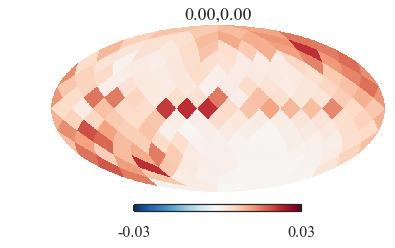

In [620]:
joint['delta_par']=joint['par']-jointinputs['parallax']
gen_fast_map_fld(joint,
                 'delta_par',nside=4,vmin=-0.03,vmax=0.03,cmap=plt.cm.RdBu_r)

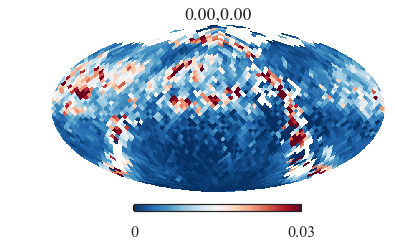

In [651]:
joint['delta_par']=joint['par']-jointinputs['parallax']
joint['ra']=jointinputs['ra']
joint['dec']=jointinputs['dec']
gen_fast_map_fld_radec(joint,
                 'delta_par',nside=16,vmin=0.,vmax=0.03,cmap=plt.cm.RdBu_r)

In [636]:
jj = Table.read('/data/jls/GaiaDR2/spectro/LAMOST_distances_MASTER.hdf5')

In [631]:
jj2 = pd.read_hdf('/data/jls/GaiaDR2/spectro/LAMOST_input_MASTER.hdf5')

In [637]:
jj = jj.to_pandas()

In [638]:
jj = pd.merge(jj[jj.source_id>0.],jj2[jj2.source_id>0.],on='source_id')

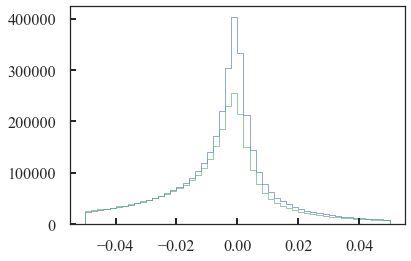

In [645]:
plt.hist(jj.parallax-jj.par,range=[-0.05,0.05],bins=50,histtype='step');
plt.hist(jointinputs.parallax-joint.par,range=[-0.05,0.05],bins=50,histtype='step');

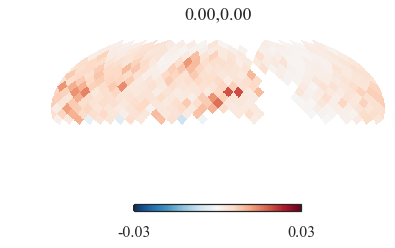

In [646]:
jj['delta_par']=jj['par']-jj['parallax']
gen_fast_map_fld_radec(jj,
                 'delta_par',nside=8,vmin=-0.03,vmax=0.03,cmap=plt.cm.RdBu_r)

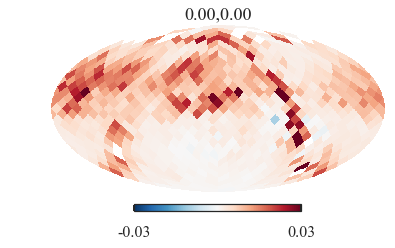

In [648]:
joint['delta_par']=joint['par']-jointinputs['parallax']
gen_fast_map_fld_radec(joint,
                 'delta_par',nside=8,vmin=-0.03,vmax=0.03,cmap=plt.cm.RdBu_r)

[]

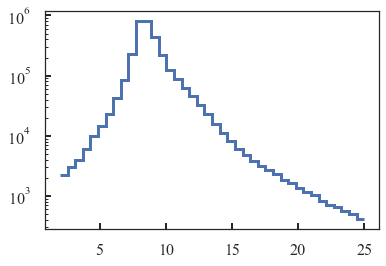

In [336]:
plt.hist(joint_table[joint_table['best']==1]['R'],range=[2.,25.],histtype='step',lw=3,bins=40);
plt.semilogy()

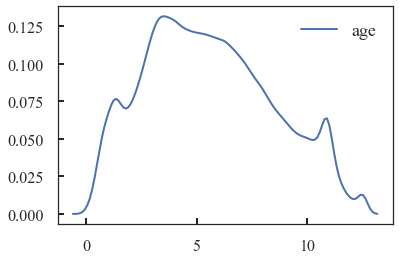

In [373]:
sns.kdeplot(joint_table[(joint_table['best']==1)&(joint_table['log10_age_err']<0.3)&(giants(joint_table))]['age'])
# plt.semilogy()

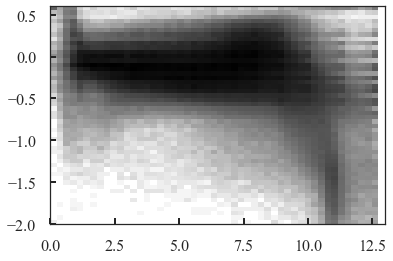

In [398]:
plt.hist2d(joint_table['age'][(joint_table['best']==1)&(joint_table['log10_age_err']<0.2)&(joint_table['survey']=='LAMOST')],
           joint_table['Z'][(joint_table['best']==1)&(joint_table['log10_age_err']<0.2)&(joint_table['survey']=='LAMOST')],
           bins=50,range=[[0.,13.],[-2.,0.6]],norm=LogNorm());

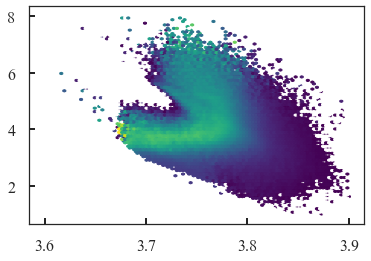

In [419]:
plt.hexbin(lamost['log10_teff'][turnoff(lamost)&(lamost['Z']>-0.8)],
           (lamost_inputs['G']-lamost['dm'])[turnoff(lamost)&(lamost['Z']>-0.8)],
           C=np.power(10.,lamost['log10_age'])[turnoff(lamost)&(lamost['Z']>-0.8)],
           extent=[3.6,3.9,1.,8.],cmap=plt.cm.viridis,vmin=1.,vmax=12.)

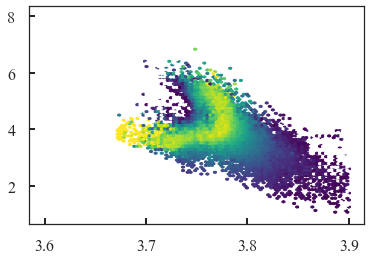

In [416]:
plt.hexbin(segue['log10_teff'][turnoff(segue)&(segue['Z']>-0.8)],
           (segue_inputs['G']-segue['dm'])[turnoff(segue)&(segue['Z']>-0.8)],
           C=np.power(10.,segue['log10_age'])[turnoff(segue)&(segue['Z']>-0.8)],
           extent=[3.6,3.9,1.,8.],cmap=plt.cm.viridis,vmin=1.,vmax=12.)

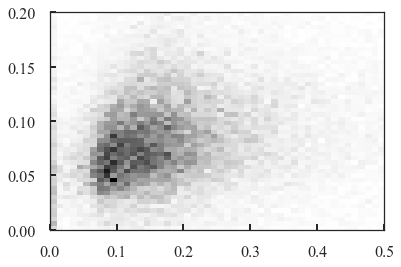

In [440]:
plt.hist2d(3.*segue['log10_age_err'][turnoff(segue)&(segue['Z']>-0.8)],
        3.*segue_inputs['e_fe_h'][turnoff(segue)&(segue['Z']>-0.8)],range=[[0.,0.5],[0.,0.2]],bins=50);

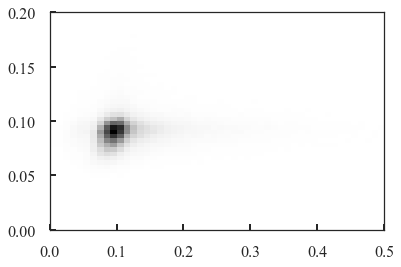

In [438]:
plt.hist2d(galah['log10_age_err'][turnoff(galah)&(galah['Z']>-0.8)],
        galah_inputs['e_fe_h'][turnoff(galah)&(galah['Z']>-0.8)],range=[[0.,0.5],[0.,0.2]],bins=50);

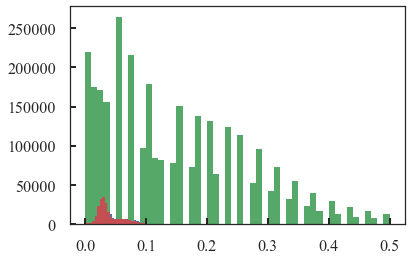

In [460]:
plt.hist(apogee_inputs['e_fe_h'],bins=50,range=[0.,.2]);
plt.hist(lamost_inputs['e_fe_h'],bins=50,range=[0.,.5]);
plt.hist(apogee['Z_err'],bins=50,range=[0.,.2]);

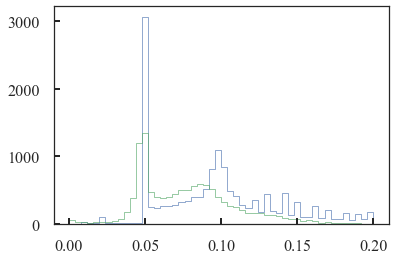

In [466]:
plt.hist(ges_inputs['e_fe_h'],bins=50,range=[0.,.2],histtype='step');
plt.hist(ges['Z_err'],bins=50,range=[0.,.2],histtype='step');

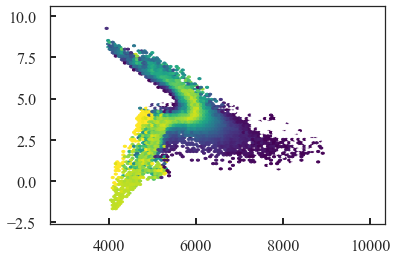

In [455]:
plt.hexbin(np.power(10.,segue['log10_teff'][(segue['Z']>-0.8)]),
           (segue_inputs['G']-segue['dm'])[(segue['Z']>-0.8)],
           C=np.power(10.,segue['log10_age'])[(segue['Z']>-0.8)],
           extent=[3000.,10000.,-2.,10.],cmap=plt.cm.viridis,vmin=1.,vmax=12.)

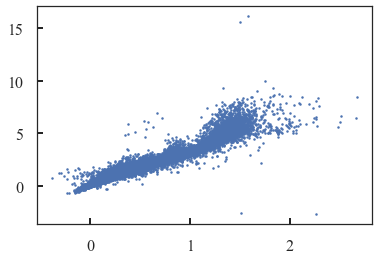

In [14]:
plt.plot((rave_inputs['J']-rave_inputs['K'])[rave['flag']==0],
         (rave_inputs['G']-rave_inputs['K'])[rave['flag']==0],'.',ms=5)
# plt.plot((rave_inputs['J']-rave_inputs['K'])[rave['flag']==1],
#          (rave_inputs['G']-rave_inputs['K'])[rave['flag']==1],'.',ms=5)
# plt.plot(apogee_inputs['J']-apogee_inputs['K'],apogee_inputs['G']-apogee_inputs['K'],'.',ms=5)
# plt.plot(galah_inputs['J']-galah_inputs['K'],galah_inputs['G']-galah_inputs['K'],'.',ms=5)

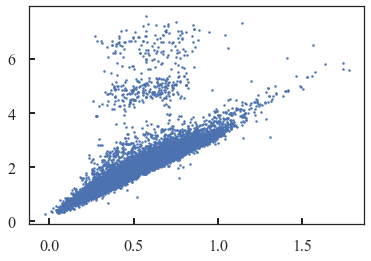

In [19]:
plt.plot((lamost_inputs['J']-lamost_inputs['K'])[lamost['flag']==6],
         (lamost_inputs['G']-lamost_inputs['K'])[lamost['flag']==6],'.',ms=5)

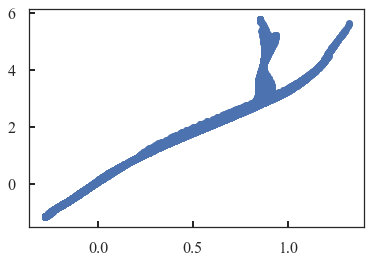

In [21]:
plt.plot(gJ.T[8]-gJ.T[10],g.T[8]-gJ.T[10],'.')


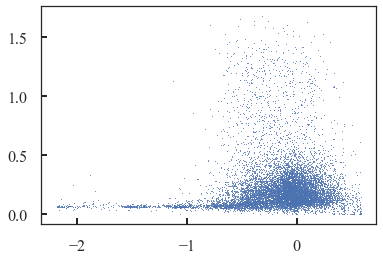

In [47]:
plt.plot(ges['Z'],ges['log10_age_err'],'.',ms=2)

In [ ]:
plt.hist2d(raveON_inputs['e_fe_h'][giants(raveON)&(raveON['Z']<-0.7)],
         raveON['log10_age_err'][giants(raveON)&(raveON['Z']<-0.7)],range=[[0.,0.2],[0.,0.4]],bins=50)
# plt.xlim(-1.,0.6)
plt.ylim(0.,0.4)
# plt.xlim(0.,150.)

(0.0, 0.8)

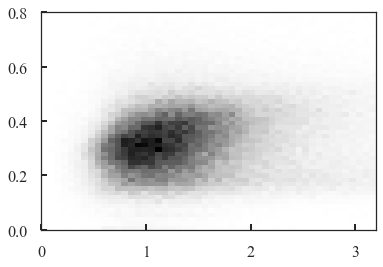

In [134]:
plt.hist2d(raveON['s'][giants(raveON)&(raveON['Z']>-0.7)],
         raveON['log10_age_err'][giants(raveON)&(raveON['Z']>-0.7)]*np.log(10.),range=[[0.,3.2],[0.,0.8]],bins=50)
# plt.xlim(-1.,0.6)
plt.ylim(0.,0.8)
# plt.xlim(0.,150.)

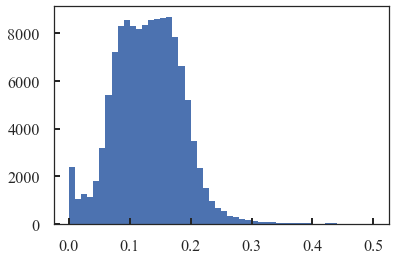

In [99]:
plt.hist(rave['log10_age_err'][giants(rave)&(rave['Z']>-0.3)],range=[0.,0.5],bins=50);

In [60]:
len(np.unique(rave['raveid'])), len(rave)

(457555, 457555)

In [61]:
len(np.unique(apogee['APOGEE_ID'])), len(apogee)

(258475, 258475)

In [62]:
len(np.unique(lamost['obsid'])), len(lamost)

(3177995, 3177995)

(-4.0, 4.0)

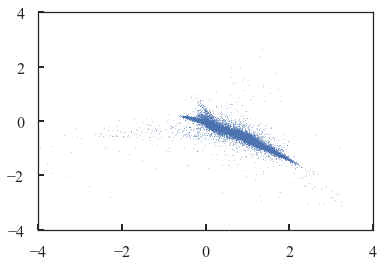

In [76]:
plt.plot(segue_inputs['g']-segue_inputs['i'],segue_inputs['G']-segue_inputs['g'],'.',ms=1)
plt.xlim(-4.,4.)
plt.ylim(-4.,4.)

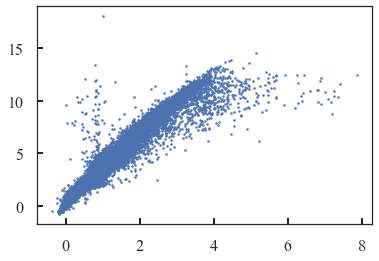

In [71]:
plt.plot(apogee_inputs['J']-apogee_inputs['K'],apogee_inputs['G']-apogee_inputs['K'],'.',ms=5)
# plt.xlim(-4.,4.)
# plt.ylim(-4.,4.)

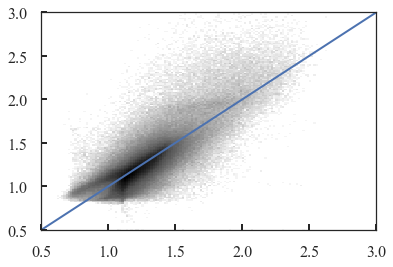

In [143]:
plt.hist2d(jointinputs['mass'],joint['mass'],range=[[0.5,3.],[0.5,3.]],bins=150,norm=LogNorm());
xx = np.linspace(0.5,3.)
plt.plot(xx,xx)

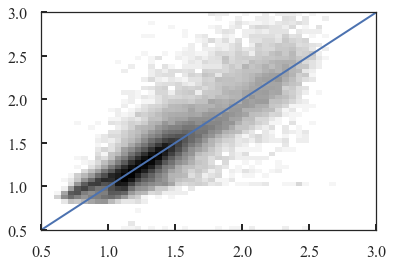

In [146]:
plt.hist2d(apogee_inputs['mass'],apogee['mass'],range=[[0.5,3.],[0.5,3.]],bins=50,norm=LogNorm());
xx = np.linspace(0.5,3.)
plt.plot(xx,xx)

[]

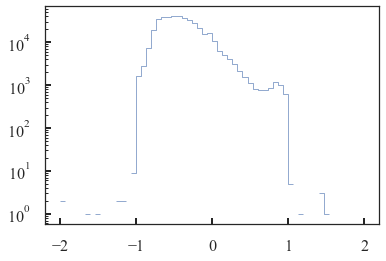

In [175]:
plt.hist(rave['log10age_Z_corr'][rave['flag']==0],
         range=[-2.,2.],histtype='step',bins=60);
plt.semilogy()

In [233]:
rfill = Table.read('/data/jls/GaiaDR2/spectro/LAMOST_distances_pm__withPRIOR.hdf5')

[]

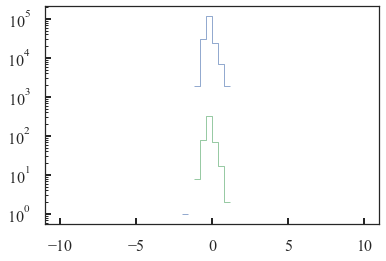

In [214]:
plt.hist(rfill['log10age_Z_corr'][rfill['flag']==0],range=[-10.,10.],bins=50,histtype='step');
plt.hist(rfill2['log10age_Z_corr'][rfill2['flag']==0],range=[-10.,10.],bins=50,histtype='step');
plt.semilogy()

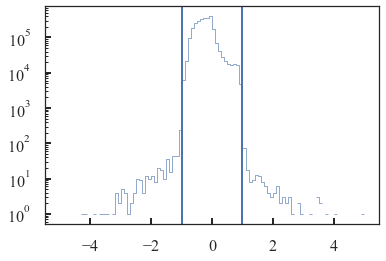

In [235]:
plt.hist(lamost['log10age_Z_corr'][lamost['flag']==0],range=[-5.,5.],bins=100,histtype='step');
plt.semilogy()
plt.axvline(1.)
plt.axvline(-1.)